In [1]:
import os
import numpy as np


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import librosa
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pickle

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Data Loading and Preprocessing
def load_data(dataset_paths):
    X, y = [], []
    for dataset_path in dataset_paths:
        for root, dirs, files in os.walk(dataset_path):
            for dir_name in dirs:
                emotion = dir_name.split('_')[1]  # Extract emotion from folder name
                emotion_path = os.path.join(root, dir_name)
                for file in os.listdir(emotion_path):
                    if file.endswith('.wav'):
                        file_path = os.path.join(emotion_path, file)
                        X.append(file_path)
                        y.append(emotion)
    return X, y


In [4]:
dataset_paths = [
    'C:\\Users\\jerom\\OneDrive\\Desktop\\hackathon\\celestini-dl-master\\archive (1)\\Crema'
    'C:\\Users\\jerom\\OneDrive\\Desktop\\hackathon\\celestini-dl-master\\archive (1)\\Ravdess'
    'C:\\Users\\jerom\\OneDrive\\Desktop\\hackathon\\celestini-dl-master\\archive (1)\\Savee'
    'C:\\Users\\jerom\\OneDrive\\Desktop\\hackathon\\celestini-dl-master\\archive (1)\\Tess'
]
X, y = load_data(dataset_paths)
print(f"Loaded {len(X)} audio files from the datasets.")


Loaded 0 audio files from the datasets.


In [5]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, duration=3, offset=0.5, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)

# Extract features for all audio files
X_features = np.array([extract_features(file_path) for file_path in X])
print(f"Extracted features from {len(X_features)} audio files.")


Extracted features from 0 audio files.


In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
print(le.classes_)


with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
for index, label in enumerate(le.classes_):
    print(f"Index {index}: {label}")

Index 0: Fear
Index 1: Pleasant
Index 2: Sad
Index 3: angry
Index 4: disgust
Index 5: fear
Index 6: happy
Index 7: neutral
Index 8: pleasant
Index 9: sad


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_categorical, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Training set size: 2240, Test set size: 560


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:

# Model Architecture
def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # CNN branch
    conv1 = Conv1D(128, kernel_size=3, activation='relu')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(256, kernel_size=3, activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling1D(pool_size=2)(conv2)
    
    # LSTM branch
    lstm = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    
    # Combine branches
    combined = Concatenate()([GlobalMaxPooling1D()(conv2), GlobalMaxPooling1D()(lstm)])
    
    # Dense layers
    dense1 = Dense(512, activation='relu')(combined)
    dense1 = BatchNormalization()(dense1)
    dense1 = Dropout(0.5)(dense1)
    dense2 = Dense(256, activation='relu')(dense1)
    dense2 = BatchNormalization()(dense2)
    dense2 = Dropout(0.5)(dense2)
    
    outputs = Dense(num_classes, activation='softmax')(dense2)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
input_shape = (X_train.shape[1], 1)
num_classes = y_train.shape[1]
model = build_model(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_reducer]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


# Save the model to a .keras file
model.save('model1.keras')

# Load the model
model = tf.keras.models.load_model('C:\\Users\\jerom\\OneDrive\\Desktop\\hackathon\\celestini-dl-master\\celestini-dl-master\\model.keras')

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.5174 - loss: 1.6356 - val_accuracy: 0.2768 - val_loss: 7.7456 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8819 - loss: 0.3567 - val_accuracy: 0.2214 - val_loss: 4.6890 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9311 - loss: 0.1956 - val_accuracy: 0.3268 - val_loss: 2.8252 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9594 - loss: 0.1253 - val_accuracy: 0.7232 - val_loss: 0.9406 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9716 - loss: 0.0926 - val_accuracy: 0.8214 - val_loss: 0.5460 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9776 - loss: 0.0747 - val_accuracy: 0.8661 - val_loss: 0.3687 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9809 - loss: 0.0524 - val_a

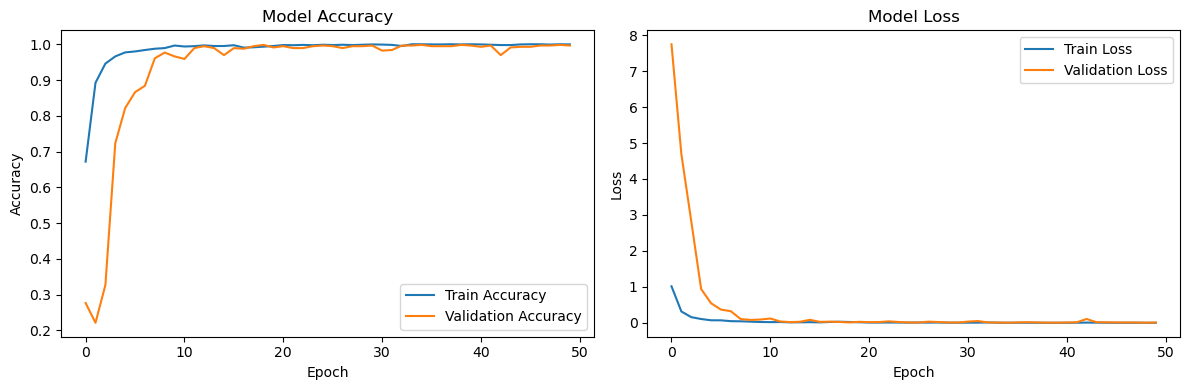

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()